In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchview import draw_graph
import graphviz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

RANDOM_SEED = 114514
BATCH_SIZE = 32
LEARN_RATE = 0.001
MAX_NUM_EPOCH = 200
VISUALIZE_MODEL = False

Current device: cuda


In [2]:
from models.CAE import CNN1D
model = CNN1D()
model.to(device)

if VISUALIZE_MODEL:
    model_graph = draw_graph(
        model,
        input_size=[(BATCH_SIZE, 84), (BATCH_SIZE, 4)],
        expand_nested=True)
    display(model_graph.visual_graph)

In [ ]:
from data.aware import AwareDataset, AwareSplitter

dataset = AwareDataset(csv_data = 'data/exhale_data_v8_ave.csv',
                       csv_outcome = 'data/exhale_outcome_v8_ave.csv',
                       csv_info = 'data/exhale_verbose_v8_ave.csv',
                       root_dir = 'data/',
                       target_classes = [0,1])

splitter = AwareSplitter(dataset, BATCH_SIZE, random_seed=RANDOM_SEED)

Outcome Columns: Index(['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score'],
      dtype='object')
Info Columns: Index(['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina'],
      dtype='object')
# of total CSA samples: 1058
# of total subjects: 340
# of valid CSA samples w/o NaN: 837
# of subjects w/ valid CSA samples: 267
# of healthy samples: 295
# of asthma sampels: 542


Fold #0

Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

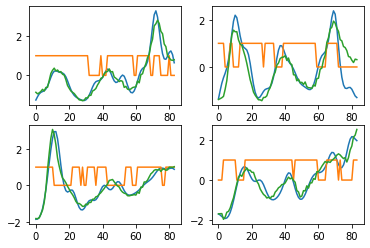

Best pre-training loss: 0.1004
On which epoch reach the highest accuracy: 191

Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Best fine-tuning accuracy (balanced): 73.83%
On which epoch reach the highest accuracy: 17
Test:
Best fine-tuning accuracy (balanced): 74.27%
On which epoch reach the highest accuracy: 17

Fold #1

Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

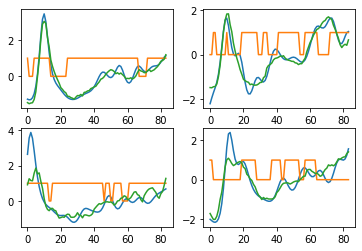

Best pre-training loss: 0.0887
On which epoch reach the highest accuracy: 155

Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Best fine-tuning accuracy (balanced): 63.52%
On which epoch reach the highest accuracy: 27
Test:
Best fine-tuning accuracy (balanced): 79.69%
On which epoch reach the highest accuracy: 27

Fold #2

Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

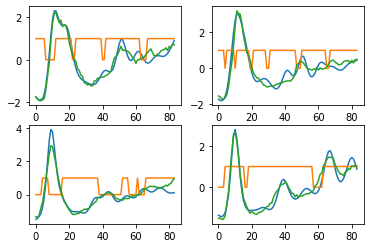

Best pre-training loss: 0.0832
On which epoch reach the highest accuracy: 171

Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Best fine-tuning accuracy (balanced): 72.61%
On which epoch reach the highest accuracy: 7
Test:
Best fine-tuning accuracy (balanced): 77.64%
On which epoch reach the highest accuracy: 7

Fold #3

Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

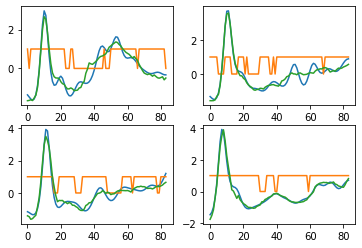

Best pre-training loss: 0.0695
On which epoch reach the highest accuracy: 166

Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Best fine-tuning accuracy (balanced): 79.26%
On which epoch reach the highest accuracy: 61
Test:
Best fine-tuning accuracy (balanced): 69.49%
On which epoch reach the highest accuracy: 61

Fold #4

Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

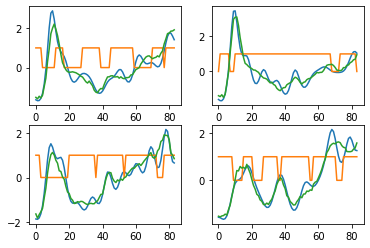

Best pre-training loss: 0.0853
On which epoch reach the highest accuracy: 163

Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Best fine-tuning accuracy (balanced): 76.16%
On which epoch reach the highest accuracy: 16
Test:
Best fine-tuning accuracy (balanced): 74.95%
On which epoch reach the highest accuracy: 16



In [4]:
import time
import jupyter_beeper

from trainer.pretrain import PreTrainer
from trainer.finetune import FineTuner
from utils.others import weight_reset, Metrics, Outputs
from utils.clustering import evaluate
from utils.outlier import novelty_detection

# metrics_cluster = np.zeros((5,3,3))
metrics_val = Metrics()
metrics_test = Metrics()
outputs_test = Outputs()

beeper = jupyter_beeper.Beeper()

timestr = time.strftime("%Y%m%d-%H%M%S")
for split_idx, (train_loader, val_loader, test_loader) in enumerate(splitter):
    print("Fold #" + str(split_idx))
    writer = SummaryWriter("runs/" + timestr + "-fold" + str(split_idx))
    model.apply(weight_reset)

    print("\nPre-training...")
    model.pre_train()
    pre_trainer = PreTrainer(
        model,
        lr = LEARN_RATE,
        T_max = MAX_NUM_EPOCH,
        device = device,
        summarywriter = writer
    )
    for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
        pre_trainer.train(epoch, train_loader)
        pre_trainer.validate(epoch, val_loader)
    pre_trainer.test(val_loader)
    
    print("\nFine-tuning...")
    model.fine_tune()
    fine_tuner = FineTuner(
        model,
        lr = LEARN_RATE,
        T_max = MAX_NUM_EPOCH,
        device = device,
        summarywriter = writer
    )
    for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
        fine_tuner.train(epoch, train_loader)
        fine_tuner.validate(epoch, val_loader)
    print("Validataion:")
    fine_tuner.test(val_loader)
    metrics_val.append_from(fine_tuner)
    print("Test:")
    fine_tuner.test(test_loader)
    metrics_test.append_from(fine_tuner)
    outputs_test.append_from(fine_tuner)
    print()
    
#     beeper.beep(frequency=600, secs=0.5)
#     novelty_detection(model, train_loader, val_loader, test_loader)
#     metrics_cluster[split_idx,:,:] = evaluate(model, train_loader, val_loader, test_loader)    


In [5]:
print("Final Validation Results")
print(metrics_val)
print()
print("Final Test Results")
print(metrics_test)
print()
beeper.beep(frequency=600, secs=0.5)

Final Validation Results
   Accuracy  Balanced_Acc  Sensitivity  Specificity     AUROC      FEV1  \
0  0.820312      0.738304     0.988235     0.488372  0.763338  0.174835   
1  0.640625      0.635236     0.658228     0.612245  0.666494  0.167545   
2  0.739130      0.726140     0.905405     0.546875  0.682010  0.160048   
3  0.814815      0.792614     0.912500     0.672727  0.824773  0.186782   
4  0.857143      0.761610     0.970588     0.552632  0.754644  0.135251   

   FEV1/FVC  
0  0.119740  
1  0.111890  
2  0.122664  
3  0.091899  
4  0.096781  
AVERAGE:
   Accuracy  Balanced_Acc  Sensitivity  Specificity     AUROC      FEV1  \
0  0.774405      0.730781     0.886991      0.57457  0.738252  0.164892   

   FEV1/FVC  
0  0.108595  

Final Test Results
   Accuracy  Balanced_Acc  Sensitivity  Specificity     AUROC      FEV1  \
0  0.773810      0.742694     0.811475     0.673913  0.822701  0.140672   
1  0.773810      0.796864     0.745902     0.847826  0.822523  0.138667   
2  0.74

171 59
146 464


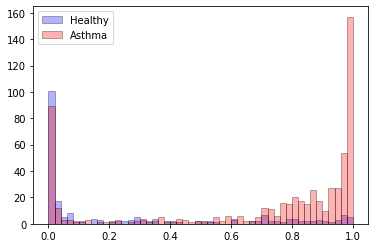

Sens: 0.760655737704918
Spec: 0.7434782608695653
BalAcc: 0.7520669992872416


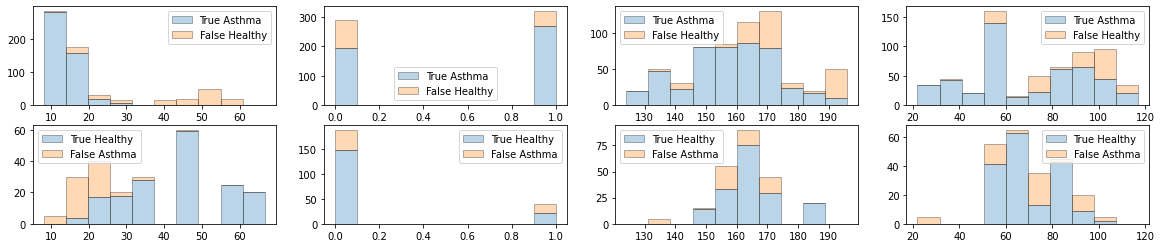

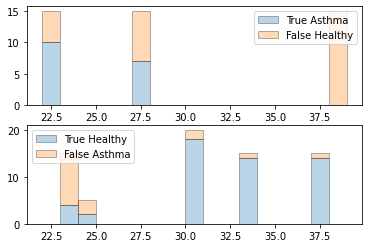

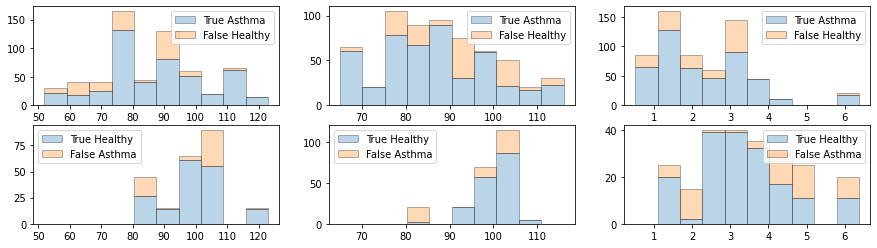

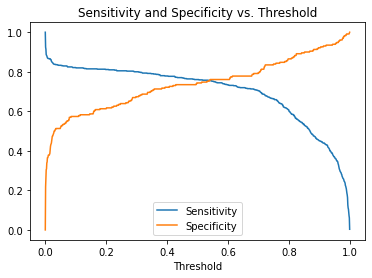

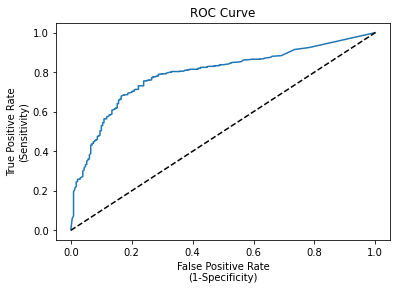

In [8]:
import ast
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd

labels = outputs_test.outputs['Labels'].to_list()
labels = pd.DataFrame(labels)
labels.columns = ['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score']

info = outputs_test.outputs['Info'].to_list()
info = pd.DataFrame(info)
info.columns = ['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina']

meta = pd.concat([labels, info], axis=1)

outputs_cls = outputs_test.outputs['Outputs_cls'].to_list()
outputs_cls = pd.DataFrame(outputs_cls)

meta.insert(1, 'Prediction', outputs_cls[1])

idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=0.5)
tp = idx_tp.sum()
idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=0.5)
fp = idx_fp.sum()
idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<0.5)
tn = idx_tn.sum()
idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<0.5)
fn = idx_fn.sum()
print(tn, fp)
print(fn, tp)

plt.figure()
plt.hist(meta['Prediction'][meta['Diagnosis']==0], bins=50, range=(0,1), alpha = 0.3, color='b', edgecolor='k', linewidth=1)
plt.hist(meta['Prediction'][meta['Diagnosis']==1], bins=50, range=(0,1), alpha = 0.3, color='r', edgecolor='k', linewidth=1)
plt.legend(['Healthy', 'Asthma'])
plt.show()

# cross_entropy = -(y_true*np.log10(y_pred[1]) + (1-y_true)*np.log10(y_pred[0]))

# plt.figure()
# # plt.hist(cross_entropy, bins=np.logspace(np.log10(0.1),np.log10(10.0), 50), edgecolor='k', linewidth=1)
# plt.hist(cross_entropy, bins=50, edgecolor='k', linewidth=1)
# plt.legend(['Healthy', 'Asthma'])
# # plt.gca().set_xscale("log")
# plt.vlines(-np.log10(0.5), 0, 500, color='r')
# plt.show()

# y_pred = y_pred.idxmax(axis=1)

sens = tp/(tp+fn)
spec = tn/(fp+tn)
print('Sens:', sens)
print('Spec:', spec)
print('BalAcc:', (sens+spec)/2)

plt.figure(figsize=(20,4))
plt.subplot(2,4,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,5)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,2)
plt.hist(pd.concat([meta['Sex'][idx_tp], meta['Sex'][idx_fn]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,6)
plt.hist(pd.concat([meta['Sex'][idx_tn], meta['Sex'][idx_fp]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,3)
plt.hist(pd.concat([meta['Height'][idx_tp], meta['Height'][idx_fn]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,7)
plt.hist(pd.concat([meta['Height'][idx_tn], meta['Height'][idx_fp]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,4)
plt.hist(pd.concat([meta['Weight'][idx_tp], meta['Weight'][idx_fn]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,8)
plt.hist(pd.concat([meta['Weight'][idx_tn], meta['Weight'][idx_fp]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), bins=list(range(22,40,1)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,1,2)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), bins=list(range(22,40,1)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(2,3,1)
plt.hist(pd.concat([meta['FEV1_pred'][idx_tp], meta['FEV1_pred'][idx_fn]], axis=1), range=(meta['FEV1_pred'].min(),meta['FEV1_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,4)
plt.hist(pd.concat([meta['FEV1_pred'][idx_tn], meta['FEV1_pred'][idx_fp]], axis=1), range=(meta['FEV1_pred'].min(),meta['FEV1_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,3,2)
plt.hist(pd.concat([meta['FEV1/FVC_pred'][idx_tp], meta['FEV1/FVC_pred'][idx_fn]], axis=1), range=(meta['FEV1/FVC_pred'].min(),meta['FEV1/FVC_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,5)
plt.hist(pd.concat([meta['FEV1/FVC_pred'][idx_tn], meta['FEV1/FVC_pred'][idx_fp]], axis=1), range=(meta['FEV1/FVC_pred'].min(),meta['FEV1/FVC_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,3,3)
plt.hist(pd.concat([meta['FEF2575'][idx_tp], meta['FEF2575'][idx_fn]], axis=1), range=(meta['FEF2575'].min(),meta['FEF2575'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,6)
plt.hist(pd.concat([meta['FEF2575'][idx_tn], meta['FEF2575'][idx_fp]], axis=1), range=(meta['FEF2575'].min(),meta['FEF2575'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

thre = np.zeros(1001)
sens = np.zeros(1001)
spec = np.zeros(1001)
for i in range(0,1001):
    idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=i/1000)
    tp = idx_tp.sum()
    idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=i/1000)
    fp = idx_fp.sum()
    idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<i/1000)
    tn = idx_tn.sum()
    idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<i/1000)
    fn = idx_fn.sum()
    thre[i] = i/1000
    sens[i] = tp/(tp+fn)
    spec[i] = tn/(fp+tn)
    
plt.figure()
plt.plot(thre, sens)
plt.plot(thre, spec)
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend(['Sensitivity', 'Specificity'])
plt.xlabel('Threshold')
plt.show()

plt.figure()
# skplt.metrics.plot_roc_curve(meta['Diagnosis'], outputs_cls)
plt.plot(1-spec, sens)
plt.plot([0,1], [0,1], '--k')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate\n(1-Specificity)')
plt.ylabel('True Positive Rate\n(Sensitivity)')
plt.show()